In [35]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import json
from model_training_process import *
import requests
import matplotlib.pyplot as plt
import os

In [36]:
class_df = pd.read_csv("..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df[["pinyin", "class_label"]]

,pinyin,class_label
0,zhi,0
1,chi,0
2,shi,0
3,ri,0
4,zi,1
...,...,...
402,xun,20
403,yong,18
404,jiong,20
405,qiong,20


In [37]:
class_df['class_label_index'] = class_df.groupby('class_label').cumcount()
class_df[["pinyin", "class_label", "class_label_index"]]

,pinyin,class_label,class_label_index
0,zhi,0,0
1,chi,0,1
2,shi,0,2
3,ri,0,3
4,zi,1,0
...,...,...,...
402,xun,20,11
403,yong,18,4
404,jiong,20,12
405,qiong,20,13


In [38]:
npy_file_path_list = glob("..\\..\\data\\*EduVer\\*")
print(f"len(npy_file_path_list): {len(npy_file_path_list)}")

len(npy_file_path_list): 67173


In [39]:
selected_npy_file_path_list = list()
for npy_file_path in npy_file_path_list:
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        selected_npy_file_path_list.append(npy_file_path)
print(f"len(npy_file_path_selected): {len(selected_npy_file_path_list)}")

len(npy_file_path_selected): 66852


In [40]:
print(len(class_df.groupby("class_label").count().index))
class_df.groupby("class_label").count().index

21


Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20],
      dtype='int64', name='class_label')

In [41]:
dic = dict()

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = list()
    dic[f"class_{i}_class_label_index_list"] = list()

for npy_file_path in tqdm(selected_npy_file_path_list):
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin

    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].values[0]
    class_label_index = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label_index"].values[0]
    # print(f"{pinyin_non_accent}, {class_label}, {class_label_index}")

    mfcc_matrix = np.load(npy_file_path)
    dic[f"class_{class_label}_mfcc_matrix_list"].append(mfcc_matrix)
    dic[f"class_{class_label}_class_label_index_list"].append(class_label_index)

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = np.array(dic[f"class_{i}_mfcc_matrix_list"])
    dic[f"class_{i}_class_label_index_list"] = np.array(dic[f"class_{i}_class_label_index_list"])

for i in range(len(class_df.groupby("class_label").count().index)):
    print(f"class_{i}_mfcc_matrix_list.shape: {dic[f'class_{i}_mfcc_matrix_list'].shape}")
    print(f"class_{i}_class_label_index_list.shape: {dic[f'class_{i}_class_label_index_list'].shape}")

100%|██████████| 66852/66852 [00:49<00:00, 1363.12it/s]


class_0_mfcc_matrix_list.shape: (3133, 13, 44)
class_0_class_label_index_list.shape: (3133,)
class_1_mfcc_matrix_list.shape: (844, 13, 44)
class_1_class_label_index_list.shape: (844,)
class_2_mfcc_matrix_list.shape: (1322, 13, 44)
class_2_class_label_index_list.shape: (1322,)
class_3_mfcc_matrix_list.shape: (5333, 13, 44)
class_3_class_label_index_list.shape: (5333,)
class_4_mfcc_matrix_list.shape: (7255, 13, 44)
class_4_class_label_index_list.shape: (7255,)
class_5_mfcc_matrix_list.shape: (4499, 13, 44)
class_5_class_label_index_list.shape: (4499,)
class_6_mfcc_matrix_list.shape: (6060, 13, 44)
class_6_class_label_index_list.shape: (6060,)
class_7_mfcc_matrix_list.shape: (3050, 13, 44)
class_7_class_label_index_list.shape: (3050,)
class_8_mfcc_matrix_list.shape: (3167, 13, 44)
class_8_class_label_index_list.shape: (3167,)
class_9_mfcc_matrix_list.shape: (2396, 13, 44)
class_9_class_label_index_list.shape: (2396,)
class_10_mfcc_matrix_list.shape: (4181, 13, 44)
class_10_class_label_ind

In [42]:
channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2

In [43]:
model_train_info_list = list()
model_list = list()

for i in tqdm(range(len(class_df.groupby("class_label").count().index))):
    
    best_params = json.load(
        open(
            file=f"..\\..\\grid_search\\method2_with_fake_data\\layer2\\best_parameters_record\\best_parameters_class{i}.json",
            mode="r"
        )
    )

    learning_rate = best_params["learning_rate"]
    num_filters = best_params["num_filters"]
    dense_units = best_params["dense_unit"]
    batch_size = best_params["batch_size"]
    epochs = best_params["epochs"]
    
    X = dic[f"class_{i}_mfcc_matrix_list"]
    y = dic[f"class_{i}_class_label_index_list"]
    
    mfcc_dim_1 = X.shape[1]
    mfcc_dim_2 = X.shape[2]
    
    X_train, X_test, y_train, y_test = get_processed_data(
        X=X,
        y=y,
        num_classes=num_classes,
        mfcc_dim_1=mfcc_dim_1,
        mfcc_dim_2=mfcc_dim_2,
        channel=channel,
        test_size=test_size,
    )

    model = get_cnn_model(
        input_shape=(mfcc_dim_1, mfcc_dim_2, channel),
        num_classes=num_classes,
        learning_rate=learning_rate,
        num_filters=num_filters,
        dense_units=dense_units
    )
    
    model_train_info = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        validation_data=(X_test, y_test)
    )
    
    model_train_info_list.append(model_train_info)
    model_list.append(model)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/500
40/40 - 1s - loss: 2.3818 - accuracy: 0.5008 - val_loss: 2.8310 - val_accuracy: 0.5965 - 1s/epoch - 34ms/step
Epoch 2/500
40/40 - 0s - loss: 0.8427 - accuracy: 0.6389 - val_loss: 1.4368 - val_accuracy: 0.3078 - 306ms/epoch - 8ms/step
Epoch 3/500
40/40 - 0s - loss: 0.8253 - accuracy: 0.6464 - val_loss: 1.1243 - val_accuracy: 0.5407 - 287ms/epoch - 7ms/step
Epoch 4/500
40/40 - 0s - loss: 0.8184 - accuracy: 0.6468 - val_loss: 0.9445 - val_accuracy: 0.6603 - 304ms/epoch - 8ms/step
Epoch 5/500
40/40 - 0s - loss: 0.7606 - accuracy: 0.6580 - val_loss: 0.9800 - val_accuracy: 0.3684 - 286ms/epoch - 7ms/step
Epoch 6/500
40/40 - 0s - loss: 0.7368 - accuracy: 0.6820 - val_loss: 1.2033 - val_accuracy: 0.2775 - 313ms/epoch - 8ms/step
Epoch 7/500
40/40 - 0s - loss: 0.6184 - accuracy: 0.7578 - val_loss: 0.9328 - val_accuracy: 0.5183 - 315ms/epoch - 8ms/step
Epoch 8/500
40/40 - 0s - loss: 0.5569 - accuracy: 0.7793 - val_loss: 0.8479 - val_accuracy: 0.6316 - 281ms/epoch - 7ms/step
Epoch 9/50

  5%|▍         | 1/21 [03:42<1:14:08, 222.44s/it]

Epoch 1/500
11/11 - 1s - loss: 5.6144 - accuracy: 0.0741 - val_loss: 5.9547 - val_accuracy: 0.0059 - 680ms/epoch - 62ms/step
Epoch 2/500
11/11 - 0s - loss: 4.8320 - accuracy: 0.4237 - val_loss: 5.8250 - val_accuracy: 0.2781 - 75ms/epoch - 7ms/step
Epoch 3/500
11/11 - 0s - loss: 4.1382 - accuracy: 0.5096 - val_loss: 5.6340 - val_accuracy: 0.2781 - 72ms/epoch - 7ms/step
Epoch 4/500
11/11 - 0s - loss: 3.5579 - accuracy: 0.5022 - val_loss: 5.3807 - val_accuracy: 0.2781 - 73ms/epoch - 7ms/step
Epoch 5/500
11/11 - 0s - loss: 3.0124 - accuracy: 0.5230 - val_loss: 5.1094 - val_accuracy: 0.2781 - 71ms/epoch - 6ms/step
Epoch 6/500
11/11 - 0s - loss: 2.5336 - accuracy: 0.5393 - val_loss: 4.8273 - val_accuracy: 0.2781 - 74ms/epoch - 7ms/step
Epoch 7/500
11/11 - 0s - loss: 2.1607 - accuracy: 0.6059 - val_loss: 4.5402 - val_accuracy: 0.3373 - 71ms/epoch - 6ms/step
Epoch 8/500
11/11 - 0s - loss: 1.8467 - accuracy: 0.6148 - val_loss: 4.2741 - val_accuracy: 0.4497 - 69ms/epoch - 6ms/step
Epoch 9/500
11

 10%|▉         | 2/21 [04:18<35:38, 112.56s/it]  

Epoch 1/250
17/17 - 1s - loss: 2.9228 - accuracy: 0.2980 - val_loss: 4.4527 - val_accuracy: 0.2755 - 674ms/epoch - 40ms/step
Epoch 2/250
17/17 - 0s - loss: 1.9516 - accuracy: 0.3377 - val_loss: 3.2090 - val_accuracy: 0.2679 - 91ms/epoch - 5ms/step
Epoch 3/250
17/17 - 0s - loss: 1.8545 - accuracy: 0.3538 - val_loss: 2.8874 - val_accuracy: 0.1698 - 116ms/epoch - 7ms/step
Epoch 4/250
17/17 - 0s - loss: 1.8264 - accuracy: 0.3680 - val_loss: 2.6487 - val_accuracy: 0.2415 - 91ms/epoch - 5ms/step
Epoch 5/250
17/17 - 0s - loss: 1.7539 - accuracy: 0.3860 - val_loss: 2.5705 - val_accuracy: 0.2075 - 96ms/epoch - 6ms/step
Epoch 6/250
17/17 - 0s - loss: 1.7427 - accuracy: 0.3888 - val_loss: 2.5133 - val_accuracy: 0.2528 - 130ms/epoch - 8ms/step
Epoch 7/250
17/17 - 0s - loss: 1.7160 - accuracy: 0.3879 - val_loss: 2.4624 - val_accuracy: 0.2415 - 87ms/epoch - 5ms/step
Epoch 8/250
17/17 - 0s - loss: 1.6484 - accuracy: 0.4276 - val_loss: 2.4222 - val_accuracy: 0.2566 - 142ms/epoch - 8ms/step
Epoch 9/250

 14%|█▍        | 3/21 [04:43<21:50, 72.80s/it] 

Epoch 1/500
134/134 - 3s - loss: 4.3963 - accuracy: 0.1615 - val_loss: 4.8048 - val_accuracy: 0.0150 - 3s/epoch - 19ms/step
Epoch 2/500
134/134 - 1s - loss: 2.9153 - accuracy: 0.2778 - val_loss: 3.9445 - val_accuracy: 0.0881 - 826ms/epoch - 6ms/step
Epoch 3/500
134/134 - 1s - loss: 2.5396 - accuracy: 0.3383 - val_loss: 3.2898 - val_accuracy: 0.2652 - 737ms/epoch - 5ms/step
Epoch 4/500
134/134 - 1s - loss: 2.3653 - accuracy: 0.3722 - val_loss: 2.6344 - val_accuracy: 0.3505 - 722ms/epoch - 5ms/step
Epoch 5/500
134/134 - 1s - loss: 2.2551 - accuracy: 0.3926 - val_loss: 2.4747 - val_accuracy: 0.3430 - 766ms/epoch - 6ms/step
Epoch 6/500
134/134 - 1s - loss: 2.1481 - accuracy: 0.4180 - val_loss: 2.3130 - val_accuracy: 0.3880 - 723ms/epoch - 5ms/step
Epoch 7/500
134/134 - 1s - loss: 2.0343 - accuracy: 0.4571 - val_loss: 2.3408 - val_accuracy: 0.3749 - 743ms/epoch - 6ms/step
Epoch 8/500
134/134 - 1s - loss: 1.7069 - accuracy: 0.6188 - val_loss: 2.5886 - val_accuracy: 0.3814 - 745ms/epoch - 6ms

 19%|█▉        | 4/21 [11:09<55:36, 196.25s/it]

Epoch 1/500
91/91 - 1s - loss: 2.8251 - accuracy: 0.2879 - val_loss: 3.2384 - val_accuracy: 0.2192 - 1s/epoch - 13ms/step
Epoch 2/500
91/91 - 1s - loss: 2.2678 - accuracy: 0.3692 - val_loss: 2.4981 - val_accuracy: 0.3019 - 658ms/epoch - 7ms/step
Epoch 3/500
91/91 - 1s - loss: 2.0894 - accuracy: 0.4108 - val_loss: 2.1912 - val_accuracy: 0.3846 - 656ms/epoch - 7ms/step
Epoch 4/500
91/91 - 1s - loss: 1.9266 - accuracy: 0.4454 - val_loss: 2.3702 - val_accuracy: 0.3598 - 654ms/epoch - 7ms/step
Epoch 5/500
91/91 - 1s - loss: 1.7639 - accuracy: 0.4935 - val_loss: 2.0886 - val_accuracy: 0.3977 - 673ms/epoch - 7ms/step
Epoch 6/500
91/91 - 1s - loss: 1.4511 - accuracy: 0.5693 - val_loss: 3.0489 - val_accuracy: 0.2895 - 629ms/epoch - 7ms/step
Epoch 7/500
91/91 - 1s - loss: 0.8751 - accuracy: 0.7457 - val_loss: 2.6023 - val_accuracy: 0.3915 - 733ms/epoch - 8ms/step
Epoch 8/500
91/91 - 1s - loss: 0.6355 - accuracy: 0.8034 - val_loss: 2.1840 - val_accuracy: 0.4232 - 689ms/epoch - 8ms/step
Epoch 9/50

 24%|██▍       | 5/21 [17:08<1:07:59, 254.96s/it]

Epoch 1/250
57/57 - 1s - loss: 3.0517 - accuracy: 0.2145 - val_loss: 3.3507 - val_accuracy: 0.1567 - 908ms/epoch - 16ms/step
Epoch 2/250
57/57 - 0s - loss: 2.3145 - accuracy: 0.3201 - val_loss: 3.1645 - val_accuracy: 0.1878 - 315ms/epoch - 6ms/step
Epoch 3/250
57/57 - 0s - loss: 2.0987 - accuracy: 0.3915 - val_loss: 2.7194 - val_accuracy: 0.2733 - 323ms/epoch - 6ms/step
Epoch 4/250
57/57 - 0s - loss: 1.9397 - accuracy: 0.4279 - val_loss: 2.5957 - val_accuracy: 0.2611 - 302ms/epoch - 5ms/step
Epoch 5/250
57/57 - 0s - loss: 1.8000 - accuracy: 0.4629 - val_loss: 2.6673 - val_accuracy: 0.2889 - 301ms/epoch - 5ms/step
Epoch 6/250
57/57 - 0s - loss: 1.4388 - accuracy: 0.5693 - val_loss: 4.0797 - val_accuracy: 0.0644 - 308ms/epoch - 5ms/step
Epoch 7/250
57/57 - 0s - loss: 0.7666 - accuracy: 0.7694 - val_loss: 5.6242 - val_accuracy: 0.1489 - 308ms/epoch - 5ms/step
Epoch 8/250
57/57 - 0s - loss: 0.5026 - accuracy: 0.8397 - val_loss: 2.3798 - val_accuracy: 0.4156 - 315ms/epoch - 6ms/step
Epoch 9

 29%|██▊       | 6/21 [18:25<48:39, 194.62s/it]  

Epoch 1/500
38/38 - 1s - loss: 3.4855 - accuracy: 0.1889 - val_loss: 4.2792 - val_accuracy: 0.1493 - 1s/epoch - 27ms/step
Epoch 2/500
38/38 - 0s - loss: 2.5092 - accuracy: 0.2962 - val_loss: 3.9148 - val_accuracy: 0.1213 - 475ms/epoch - 12ms/step
Epoch 3/500
38/38 - 0s - loss: 2.2195 - accuracy: 0.3756 - val_loss: 3.6371 - val_accuracy: 0.0256 - 469ms/epoch - 12ms/step
Epoch 4/500
38/38 - 1s - loss: 2.0264 - accuracy: 0.4156 - val_loss: 3.5857 - val_accuracy: 0.0734 - 521ms/epoch - 14ms/step
Epoch 5/500
38/38 - 0s - loss: 1.8899 - accuracy: 0.4554 - val_loss: 3.6524 - val_accuracy: 0.1650 - 481ms/epoch - 13ms/step
Epoch 6/500
38/38 - 1s - loss: 1.7713 - accuracy: 0.4851 - val_loss: 3.8728 - val_accuracy: 0.0891 - 508ms/epoch - 13ms/step
Epoch 7/500
38/38 - 0s - loss: 1.6367 - accuracy: 0.5126 - val_loss: 3.3722 - val_accuracy: 0.1477 - 466ms/epoch - 12ms/step
Epoch 8/500
38/38 - 0s - loss: 1.3197 - accuracy: 0.6025 - val_loss: 4.8676 - val_accuracy: 0.0198 - 468ms/epoch - 12ms/step
Epo

 33%|███▎      | 7/21 [22:48<50:39, 217.09s/it]

Epoch 1/500
39/39 - 1s - loss: 3.1786 - accuracy: 0.2246 - val_loss: 3.7906 - val_accuracy: 0.2426 - 801ms/epoch - 21ms/step
Epoch 2/500
39/39 - 0s - loss: 2.4725 - accuracy: 0.2844 - val_loss: 3.2321 - val_accuracy: 0.1459 - 229ms/epoch - 6ms/step
Epoch 3/500
39/39 - 0s - loss: 2.2926 - accuracy: 0.3500 - val_loss: 3.2660 - val_accuracy: 0.1328 - 214ms/epoch - 5ms/step
Epoch 4/500
39/39 - 0s - loss: 2.1311 - accuracy: 0.3832 - val_loss: 3.0510 - val_accuracy: 0.2098 - 221ms/epoch - 6ms/step
Epoch 5/500
39/39 - 0s - loss: 2.0740 - accuracy: 0.4033 - val_loss: 2.8708 - val_accuracy: 0.2311 - 218ms/epoch - 6ms/step
Epoch 6/500
39/39 - 0s - loss: 1.9509 - accuracy: 0.4225 - val_loss: 2.5309 - val_accuracy: 0.2623 - 212ms/epoch - 5ms/step
Epoch 7/500
39/39 - 0s - loss: 1.9001 - accuracy: 0.4471 - val_loss: 2.5592 - val_accuracy: 0.3295 - 241ms/epoch - 6ms/step
Epoch 8/500
39/39 - 0s - loss: 1.8661 - accuracy: 0.4475 - val_loss: 2.9181 - val_accuracy: 0.2836 - 211ms/epoch - 5ms/step
Epoch 9

 38%|███▊      | 8/21 [24:35<39:25, 181.96s/it]

Epoch 1/250
40/40 - 1s - loss: 1.9738 - accuracy: 0.4919 - val_loss: 2.9401 - val_accuracy: 0.3659 - 792ms/epoch - 20ms/step
Epoch 2/250
40/40 - 0s - loss: 1.2478 - accuracy: 0.5642 - val_loss: 2.2326 - val_accuracy: 0.3281 - 231ms/epoch - 6ms/step
Epoch 3/250
40/40 - 0s - loss: 1.1281 - accuracy: 0.6017 - val_loss: 2.0772 - val_accuracy: 0.3360 - 214ms/epoch - 5ms/step
Epoch 4/250
40/40 - 0s - loss: 1.0488 - accuracy: 0.6297 - val_loss: 2.2816 - val_accuracy: 0.2114 - 219ms/epoch - 5ms/step
Epoch 5/250
40/40 - 0s - loss: 0.9585 - accuracy: 0.6629 - val_loss: 1.6492 - val_accuracy: 0.4953 - 227ms/epoch - 6ms/step
Epoch 6/250
40/40 - 0s - loss: 0.8900 - accuracy: 0.6865 - val_loss: 2.2896 - val_accuracy: 0.2823 - 217ms/epoch - 5ms/step
Epoch 7/250
40/40 - 0s - loss: 0.8432 - accuracy: 0.7098 - val_loss: 1.5480 - val_accuracy: 0.5095 - 211ms/epoch - 5ms/step
Epoch 8/250
40/40 - 0s - loss: 0.6506 - accuracy: 0.7785 - val_loss: 3.1864 - val_accuracy: 0.1420 - 209ms/epoch - 5ms/step
Epoch 9

 43%|████▎     | 9/21 [25:32<28:35, 142.93s/it]

Epoch 1/250
30/30 - 1s - loss: 3.5752 - accuracy: 0.1602 - val_loss: 4.3916 - val_accuracy: 0.1708 - 730ms/epoch - 24ms/step
Epoch 2/250
30/30 - 0s - loss: 2.4020 - accuracy: 0.2338 - val_loss: 3.4898 - val_accuracy: 0.1396 - 154ms/epoch - 5ms/step
Epoch 3/250
30/30 - 0s - loss: 2.2792 - accuracy: 0.2651 - val_loss: 3.0892 - val_accuracy: 0.1333 - 154ms/epoch - 5ms/step
Epoch 4/250
30/30 - 0s - loss: 2.1737 - accuracy: 0.2902 - val_loss: 2.9923 - val_accuracy: 0.1833 - 153ms/epoch - 5ms/step
Epoch 5/250
30/30 - 0s - loss: 2.1298 - accuracy: 0.3027 - val_loss: 2.7402 - val_accuracy: 0.2375 - 159ms/epoch - 5ms/step
Epoch 6/250
30/30 - 0s - loss: 2.0445 - accuracy: 0.3372 - val_loss: 2.6762 - val_accuracy: 0.2521 - 164ms/epoch - 5ms/step
Epoch 7/250
30/30 - 0s - loss: 1.9504 - accuracy: 0.3601 - val_loss: 2.6364 - val_accuracy: 0.2313 - 163ms/epoch - 5ms/step
Epoch 8/250
30/30 - 0s - loss: 1.8472 - accuracy: 0.4118 - val_loss: 2.6737 - val_accuracy: 0.2937 - 159ms/epoch - 5ms/step
Epoch 9

 48%|████▊     | 10/21 [26:15<20:31, 111.99s/it]

Epoch 1/500
27/27 - 1s - loss: 3.4901 - accuracy: 0.1956 - val_loss: 4.5736 - val_accuracy: 0.1087 - 903ms/epoch - 33ms/step
Epoch 2/500
27/27 - 0s - loss: 2.3434 - accuracy: 0.3116 - val_loss: 3.6173 - val_accuracy: 0.1183 - 170ms/epoch - 6ms/step
Epoch 3/500
27/27 - 0s - loss: 2.1296 - accuracy: 0.3618 - val_loss: 3.3711 - val_accuracy: 0.1147 - 167ms/epoch - 6ms/step
Epoch 4/500
27/27 - 0s - loss: 1.9722 - accuracy: 0.4115 - val_loss: 3.2357 - val_accuracy: 0.1219 - 168ms/epoch - 6ms/step
Epoch 5/500
27/27 - 0s - loss: 1.8218 - accuracy: 0.4539 - val_loss: 3.1833 - val_accuracy: 0.1278 - 166ms/epoch - 6ms/step
Epoch 6/500
27/27 - 0s - loss: 1.7798 - accuracy: 0.4611 - val_loss: 3.0850 - val_accuracy: 0.1697 - 170ms/epoch - 6ms/step
Epoch 7/500
27/27 - 0s - loss: 1.6470 - accuracy: 0.4940 - val_loss: 3.5627 - val_accuracy: 0.0514 - 167ms/epoch - 6ms/step
Epoch 8/500
27/27 - 0s - loss: 1.4680 - accuracy: 0.5634 - val_loss: 3.6561 - val_accuracy: 0.0621 - 163ms/epoch - 6ms/step
Epoch 9

 52%|█████▏    | 11/21 [27:34<16:58, 101.89s/it]

Epoch 1/500
49/49 - 1s - loss: 3.1224 - accuracy: 0.2005 - val_loss: 3.9444 - val_accuracy: 0.1080 - 1s/epoch - 24ms/step
Epoch 2/500
49/49 - 1s - loss: 2.0874 - accuracy: 0.3465 - val_loss: 3.5181 - val_accuracy: 0.0696 - 585ms/epoch - 12ms/step
Epoch 3/500
49/49 - 1s - loss: 1.8276 - accuracy: 0.4304 - val_loss: 3.1980 - val_accuracy: 0.1327 - 606ms/epoch - 12ms/step
Epoch 4/500
49/49 - 1s - loss: 1.6515 - accuracy: 0.4749 - val_loss: 3.9588 - val_accuracy: 0.0982 - 563ms/epoch - 11ms/step
Epoch 5/500
49/49 - 1s - loss: 1.5451 - accuracy: 0.5053 - val_loss: 4.4422 - val_accuracy: 0.1431 - 618ms/epoch - 13ms/step
Epoch 6/500
49/49 - 1s - loss: 1.4638 - accuracy: 0.5289 - val_loss: 3.2490 - val_accuracy: 0.1574 - 602ms/epoch - 12ms/step
Epoch 7/500
49/49 - 1s - loss: 1.3778 - accuracy: 0.5552 - val_loss: 5.6179 - val_accuracy: 0.0839 - 614ms/epoch - 13ms/step
Epoch 8/500
49/49 - 1s - loss: 1.2442 - accuracy: 0.5932 - val_loss: 4.7827 - val_accuracy: 0.1152 - 649ms/epoch - 13ms/step
Epo

 57%|█████▋    | 12/21 [32:56<25:19, 168.83s/it]

Epoch 1/250
47/47 - 1s - loss: 2.2959 - accuracy: 0.3964 - val_loss: 2.8028 - val_accuracy: 0.2911 - 797ms/epoch - 17ms/step
Epoch 2/250
47/47 - 0s - loss: 1.3037 - accuracy: 0.5206 - val_loss: 2.1828 - val_accuracy: 0.1321 - 218ms/epoch - 5ms/step
Epoch 3/250
47/47 - 0s - loss: 1.1808 - accuracy: 0.5517 - val_loss: 2.4460 - val_accuracy: 0.1321 - 211ms/epoch - 4ms/step
Epoch 4/250
47/47 - 0s - loss: 1.1232 - accuracy: 0.5793 - val_loss: 2.0788 - val_accuracy: 0.3127 - 213ms/epoch - 5ms/step
Epoch 5/250
47/47 - 0s - loss: 0.9847 - accuracy: 0.6313 - val_loss: 2.8461 - val_accuracy: 0.1536 - 214ms/epoch - 5ms/step
Epoch 6/250
47/47 - 0s - loss: 0.8574 - accuracy: 0.6840 - val_loss: 2.6616 - val_accuracy: 0.1995 - 211ms/epoch - 4ms/step
Epoch 7/250
47/47 - 0s - loss: 0.6057 - accuracy: 0.7941 - val_loss: 2.6443 - val_accuracy: 0.2291 - 210ms/epoch - 4ms/step
Epoch 8/250
47/47 - 0s - loss: 0.4109 - accuracy: 0.8683 - val_loss: 2.1556 - val_accuracy: 0.4528 - 215ms/epoch - 5ms/step
Epoch 9

 62%|██████▏   | 13/21 [33:55<18:04, 135.60s/it]

Epoch 1/500
22/22 - 1s - loss: 2.2484 - accuracy: 0.5221 - val_loss: 4.2533 - val_accuracy: 0.5848 - 684ms/epoch - 31ms/step
Epoch 2/500
22/22 - 0s - loss: 1.0369 - accuracy: 0.6029 - val_loss: 2.0426 - val_accuracy: 0.1579 - 116ms/epoch - 5ms/step
Epoch 3/500
22/22 - 0s - loss: 0.9318 - accuracy: 0.6485 - val_loss: 1.4070 - val_accuracy: 0.5263 - 115ms/epoch - 5ms/step
Epoch 4/500
22/22 - 0s - loss: 0.9417 - accuracy: 0.6412 - val_loss: 1.3276 - val_accuracy: 0.5673 - 113ms/epoch - 5ms/step
Epoch 5/500
22/22 - 0s - loss: 0.8374 - accuracy: 0.6676 - val_loss: 1.3778 - val_accuracy: 0.5322 - 117ms/epoch - 5ms/step
Epoch 6/500
22/22 - 0s - loss: 0.8229 - accuracy: 0.6588 - val_loss: 1.4834 - val_accuracy: 0.2690 - 107ms/epoch - 5ms/step
Epoch 7/500
22/22 - 0s - loss: 0.8355 - accuracy: 0.6647 - val_loss: 1.3584 - val_accuracy: 0.4503 - 122ms/epoch - 6ms/step
Epoch 8/500
22/22 - 0s - loss: 0.8257 - accuracy: 0.6559 - val_loss: 1.1913 - val_accuracy: 0.6199 - 116ms/epoch - 5ms/step
Epoch 9

 67%|██████▋   | 14/21 [34:55<13:08, 112.63s/it]

Epoch 1/250
67/67 - 1s - loss: 3.0425 - accuracy: 0.1877 - val_loss: 3.5658 - val_accuracy: 0.0640 - 905ms/epoch - 14ms/step
Epoch 2/250
67/67 - 0s - loss: 2.4362 - accuracy: 0.2325 - val_loss: 3.0788 - val_accuracy: 0.0508 - 313ms/epoch - 5ms/step
Epoch 3/250
67/67 - 0s - loss: 2.2093 - accuracy: 0.3146 - val_loss: 2.9434 - val_accuracy: 0.1299 - 307ms/epoch - 5ms/step
Epoch 4/250
67/67 - 0s - loss: 2.0451 - accuracy: 0.3708 - val_loss: 2.6160 - val_accuracy: 0.2279 - 314ms/epoch - 5ms/step
Epoch 5/250
67/67 - 0s - loss: 1.9228 - accuracy: 0.4028 - val_loss: 2.4496 - val_accuracy: 0.3051 - 317ms/epoch - 5ms/step
Epoch 6/250
67/67 - 0s - loss: 1.6691 - accuracy: 0.4877 - val_loss: 2.7727 - val_accuracy: 0.1902 - 326ms/epoch - 5ms/step
Epoch 7/250
67/67 - 0s - loss: 0.9764 - accuracy: 0.7231 - val_loss: 2.9860 - val_accuracy: 0.2128 - 305ms/epoch - 5ms/step
Epoch 8/250
67/67 - 0s - loss: 0.5277 - accuracy: 0.8575 - val_loss: 1.6385 - val_accuracy: 0.4275 - 328ms/epoch - 5ms/step
Epoch 9

 71%|███████▏  | 15/21 [36:14<10:14, 102.47s/it]

Epoch 1/250
90/90 - 1s - loss: 3.1681 - accuracy: 0.1657 - val_loss: 3.3085 - val_accuracy: 0.0628 - 1s/epoch - 12ms/step
Epoch 2/250
90/90 - 0s - loss: 2.7313 - accuracy: 0.2135 - val_loss: 3.2603 - val_accuracy: 0.0628 - 485ms/epoch - 5ms/step
Epoch 3/250
90/90 - 0s - loss: 2.5560 - accuracy: 0.2558 - val_loss: 3.3386 - val_accuracy: 0.1102 - 472ms/epoch - 5ms/step
Epoch 4/250
90/90 - 0s - loss: 2.4360 - accuracy: 0.3057 - val_loss: 2.7826 - val_accuracy: 0.2245 - 473ms/epoch - 5ms/step
Epoch 5/250
90/90 - 0s - loss: 2.2603 - accuracy: 0.3461 - val_loss: 3.1625 - val_accuracy: 0.2078 - 487ms/epoch - 5ms/step
Epoch 6/250
90/90 - 0s - loss: 2.0269 - accuracy: 0.4093 - val_loss: 2.6452 - val_accuracy: 0.2831 - 471ms/epoch - 5ms/step
Epoch 7/250
90/90 - 0s - loss: 1.3468 - accuracy: 0.6068 - val_loss: 3.4714 - val_accuracy: 0.1743 - 494ms/epoch - 5ms/step
Epoch 8/250
90/90 - 0s - loss: 0.8042 - accuracy: 0.7648 - val_loss: 1.7010 - val_accuracy: 0.4923 - 477ms/epoch - 5ms/step
Epoch 9/25

 76%|███████▌  | 16/21 [38:23<09:12, 110.52s/it]

Epoch 1/500
46/46 - 1s - loss: 3.2313 - accuracy: 0.2014 - val_loss: 3.2671 - val_accuracy: 0.1456 - 988ms/epoch - 21ms/step
Epoch 2/500
46/46 - 0s - loss: 2.6432 - accuracy: 0.2576 - val_loss: 3.3594 - val_accuracy: 0.1116 - 375ms/epoch - 8ms/step
Epoch 3/500
46/46 - 0s - loss: 2.4990 - accuracy: 0.2725 - val_loss: 3.3674 - val_accuracy: 0.0571 - 343ms/epoch - 7ms/step
Epoch 4/500
46/46 - 0s - loss: 2.4215 - accuracy: 0.3052 - val_loss: 3.3685 - val_accuracy: 0.1224 - 371ms/epoch - 8ms/step
Epoch 5/500
46/46 - 0s - loss: 2.3369 - accuracy: 0.3158 - val_loss: 3.3291 - val_accuracy: 0.1347 - 349ms/epoch - 8ms/step
Epoch 6/500
46/46 - 0s - loss: 2.2307 - accuracy: 0.3549 - val_loss: 3.8428 - val_accuracy: 0.1442 - 377ms/epoch - 8ms/step
Epoch 7/500
46/46 - 0s - loss: 2.1045 - accuracy: 0.3858 - val_loss: 5.2058 - val_accuracy: 0.1252 - 333ms/epoch - 7ms/step
Epoch 8/500
46/46 - 0s - loss: 1.9234 - accuracy: 0.4206 - val_loss: 6.4483 - val_accuracy: 0.1252 - 340ms/epoch - 7ms/step
Epoch 9

 81%|████████  | 17/21 [41:34<08:58, 134.69s/it]

Epoch 1/250
53/53 - 1s - loss: 3.2870 - accuracy: 0.1619 - val_loss: 3.4552 - val_accuracy: 0.0544 - 821ms/epoch - 15ms/step
Epoch 2/250
53/53 - 0s - loss: 2.4364 - accuracy: 0.2175 - val_loss: 3.0984 - val_accuracy: 0.0520 - 236ms/epoch - 4ms/step
Epoch 3/250
53/53 - 0s - loss: 2.2930 - accuracy: 0.2636 - val_loss: 3.0266 - val_accuracy: 0.0591 - 230ms/epoch - 4ms/step
Epoch 4/250
53/53 - 0s - loss: 2.2621 - accuracy: 0.2589 - val_loss: 2.8969 - val_accuracy: 0.0733 - 232ms/epoch - 4ms/step
Epoch 5/250
53/53 - 0s - loss: 2.1541 - accuracy: 0.2979 - val_loss: 2.8910 - val_accuracy: 0.1371 - 236ms/epoch - 4ms/step
Epoch 6/250
53/53 - 0s - loss: 2.0612 - accuracy: 0.3251 - val_loss: 4.2006 - val_accuracy: 0.0969 - 230ms/epoch - 4ms/step
Epoch 7/250
53/53 - 0s - loss: 1.8851 - accuracy: 0.3694 - val_loss: 8.3280 - val_accuracy: 0.0189 - 233ms/epoch - 4ms/step
Epoch 8/250
53/53 - 0s - loss: 1.6301 - accuracy: 0.4551 - val_loss: 14.2992 - val_accuracy: 0.0165 - 230ms/epoch - 4ms/step
Epoch 

 86%|████████▌ | 18/21 [42:36<05:39, 113.08s/it]

Epoch 1/500
23/23 - 1s - loss: 2.9941 - accuracy: 0.3967 - val_loss: 4.8522 - val_accuracy: 0.3407 - 874ms/epoch - 38ms/step
Epoch 2/500
23/23 - 0s - loss: 1.1106 - accuracy: 0.5620 - val_loss: 2.8173 - val_accuracy: 0.2857 - 124ms/epoch - 5ms/step
Epoch 3/500
23/23 - 0s - loss: 0.9258 - accuracy: 0.6336 - val_loss: 2.0146 - val_accuracy: 0.3681 - 107ms/epoch - 5ms/step
Epoch 4/500
23/23 - 0s - loss: 0.9085 - accuracy: 0.6116 - val_loss: 1.8600 - val_accuracy: 0.1703 - 104ms/epoch - 5ms/step
Epoch 5/500
23/23 - 0s - loss: 0.8675 - accuracy: 0.6364 - val_loss: 1.6832 - val_accuracy: 0.2143 - 104ms/epoch - 5ms/step
Epoch 6/500
23/23 - 0s - loss: 0.7874 - accuracy: 0.6639 - val_loss: 1.7330 - val_accuracy: 0.1813 - 103ms/epoch - 4ms/step
Epoch 7/500
23/23 - 0s - loss: 0.7464 - accuracy: 0.6708 - val_loss: 1.6624 - val_accuracy: 0.2143 - 113ms/epoch - 5ms/step
Epoch 8/500
23/23 - 0s - loss: 0.6944 - accuracy: 0.6997 - val_loss: 1.9482 - val_accuracy: 0.1319 - 105ms/epoch - 5ms/step
Epoch 9

 90%|█████████ | 19/21 [43:33<03:12, 96.03s/it] 

Epoch 1/500
7/7 - 1s - loss: 5.4087 - accuracy: 0.1709 - val_loss: 5.4431 - val_accuracy: 0.3600 - 620ms/epoch - 89ms/step
Epoch 2/500
7/7 - 0s - loss: 3.4288 - accuracy: 0.3266 - val_loss: 4.9088 - val_accuracy: 0.3600 - 55ms/epoch - 8ms/step
Epoch 3/500
7/7 - 0s - loss: 1.8929 - accuracy: 0.3417 - val_loss: 3.8110 - val_accuracy: 0.3600 - 53ms/epoch - 8ms/step
Epoch 4/500
7/7 - 0s - loss: 1.3626 - accuracy: 0.4221 - val_loss: 3.5432 - val_accuracy: 0.2400 - 54ms/epoch - 8ms/step
Epoch 5/500
7/7 - 0s - loss: 1.2852 - accuracy: 0.3618 - val_loss: 3.0232 - val_accuracy: 0.2200 - 54ms/epoch - 8ms/step
Epoch 6/500
7/7 - 0s - loss: 1.2559 - accuracy: 0.4020 - val_loss: 2.4435 - val_accuracy: 0.2400 - 63ms/epoch - 9ms/step
Epoch 7/500
7/7 - 0s - loss: 1.2305 - accuracy: 0.3970 - val_loss: 2.3897 - val_accuracy: 0.2600 - 98ms/epoch - 14ms/step
Epoch 8/500
7/7 - 0s - loss: 1.1894 - accuracy: 0.4523 - val_loss: 2.1153 - val_accuracy: 0.2600 - 48ms/epoch - 7ms/step
Epoch 9/500
7/7 - 0s - loss: 

 95%|█████████▌| 20/21 [44:01<01:15, 75.60s/it]

Epoch 1/500
52/52 - 1s - loss: 3.0736 - accuracy: 0.1881 - val_loss: 3.4522 - val_accuracy: 0.1366 - 779ms/epoch - 15ms/step
Epoch 2/500
52/52 - 0s - loss: 2.2650 - accuracy: 0.2547 - val_loss: 2.7906 - val_accuracy: 0.0927 - 226ms/epoch - 4ms/step
Epoch 3/500
52/52 - 0s - loss: 2.1941 - accuracy: 0.2541 - val_loss: 2.6057 - val_accuracy: 0.2415 - 238ms/epoch - 5ms/step
Epoch 4/500
52/52 - 0s - loss: 2.1130 - accuracy: 0.3036 - val_loss: 2.6373 - val_accuracy: 0.0805 - 236ms/epoch - 5ms/step
Epoch 5/500
52/52 - 0s - loss: 2.0405 - accuracy: 0.3256 - val_loss: 2.2350 - val_accuracy: 0.2732 - 247ms/epoch - 5ms/step
Epoch 6/500
52/52 - 0s - loss: 1.9910 - accuracy: 0.3366 - val_loss: 2.4827 - val_accuracy: 0.2415 - 245ms/epoch - 5ms/step
Epoch 7/500
52/52 - 0s - loss: 1.9221 - accuracy: 0.3506 - val_loss: 2.3689 - val_accuracy: 0.2659 - 243ms/epoch - 5ms/step
Epoch 8/500
52/52 - 0s - loss: 1.8835 - accuracy: 0.3665 - val_loss: 2.0773 - val_accuracy: 0.3244 - 235ms/epoch - 5ms/step
Epoch 9

100%|██████████| 21/21 [46:04<00:00, 131.65s/it]


In [44]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn method2 layer2 with fake data模型訓練已完成!"}
)

<Response [204]>

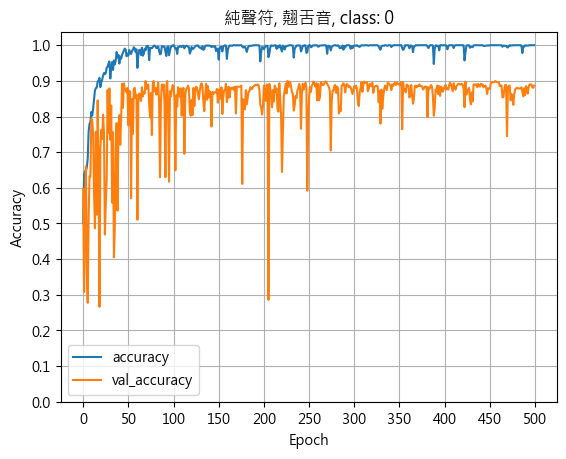

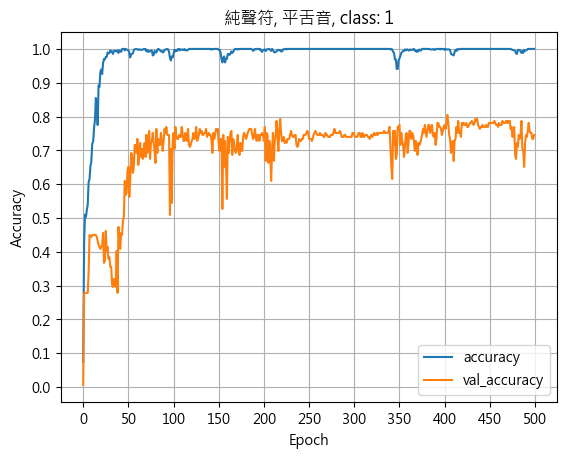

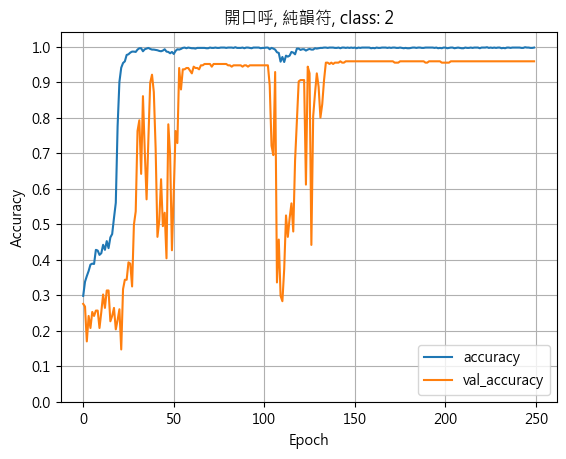

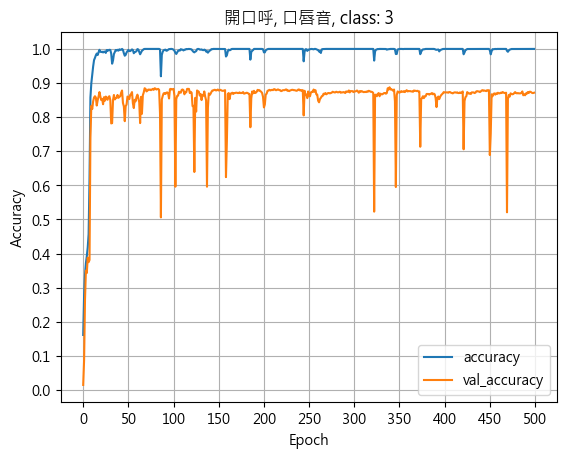

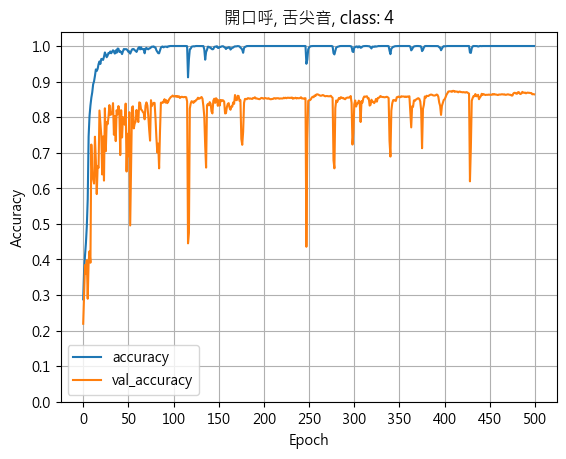

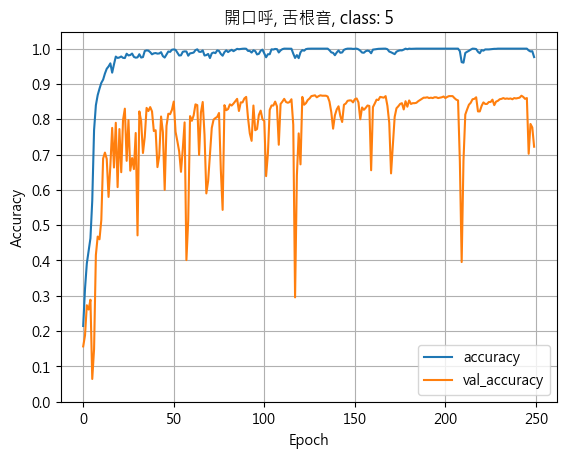

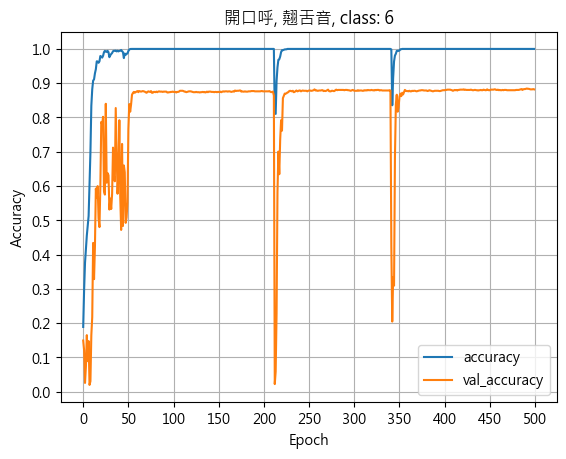

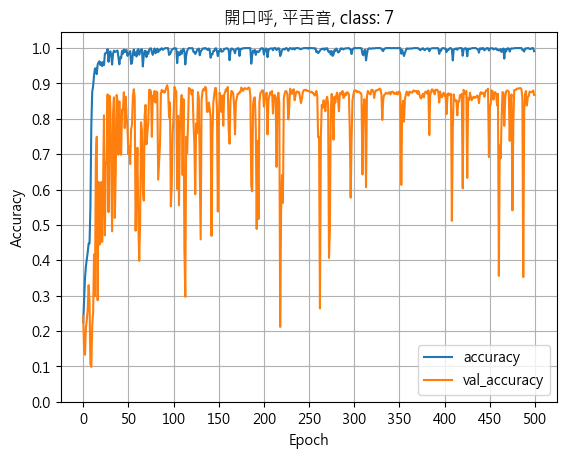

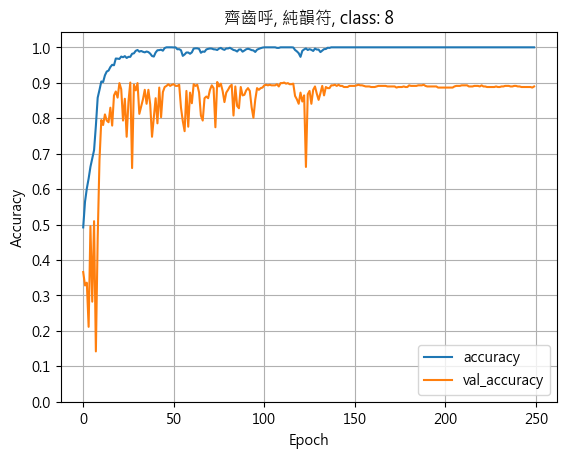

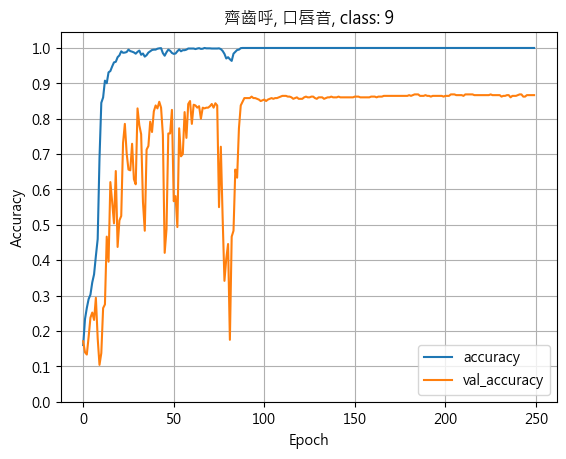

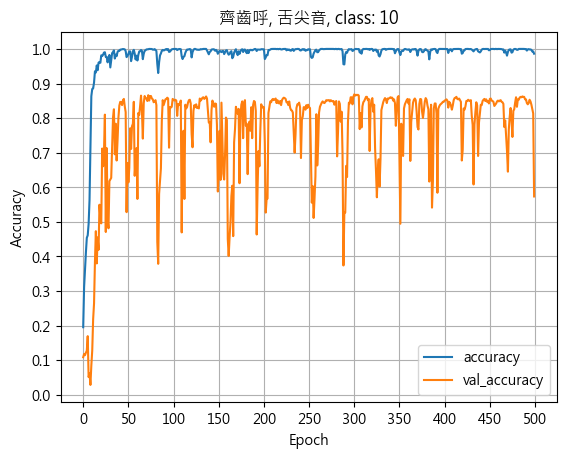

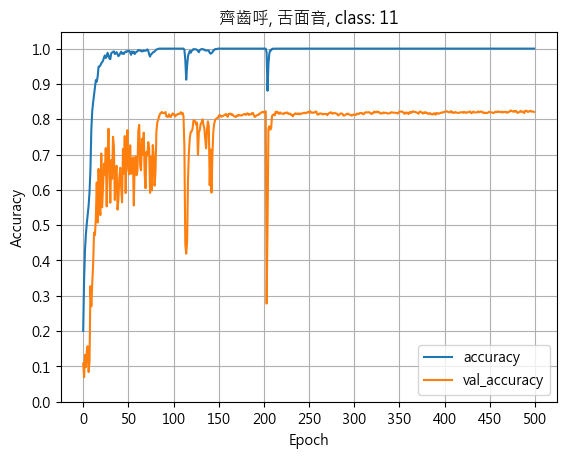

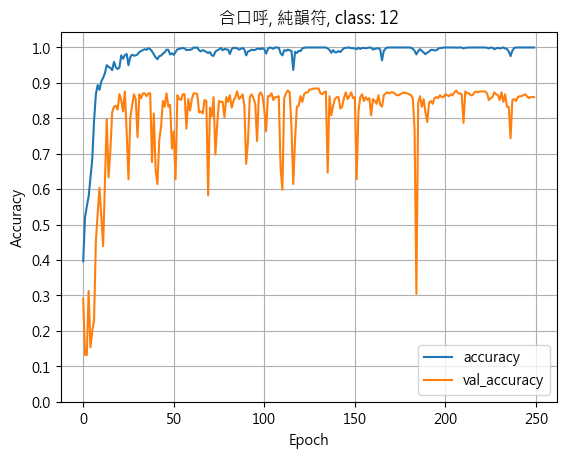

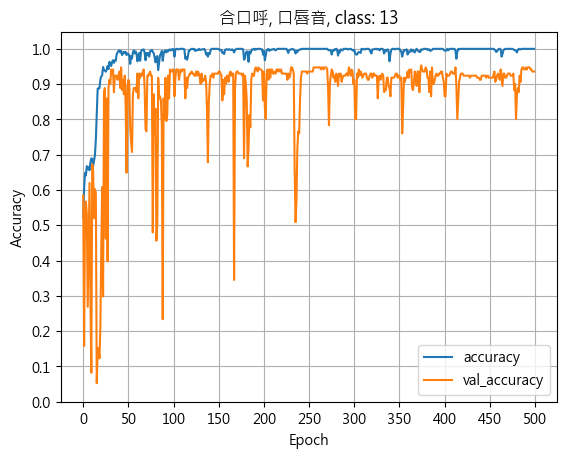

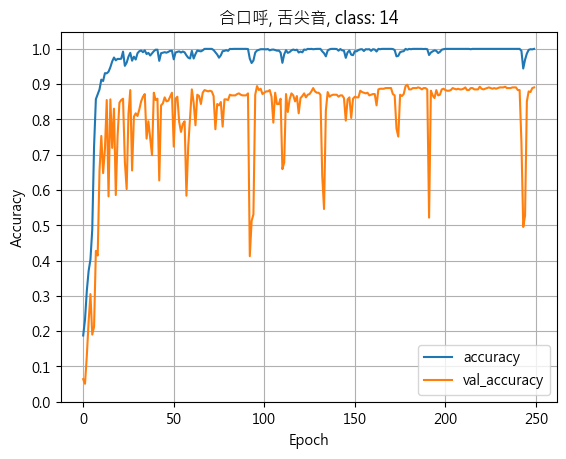

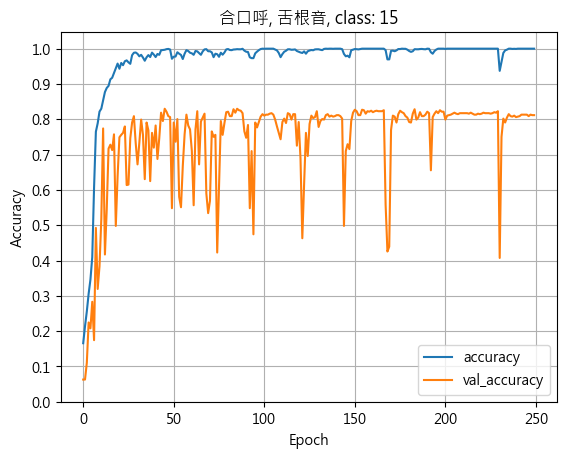

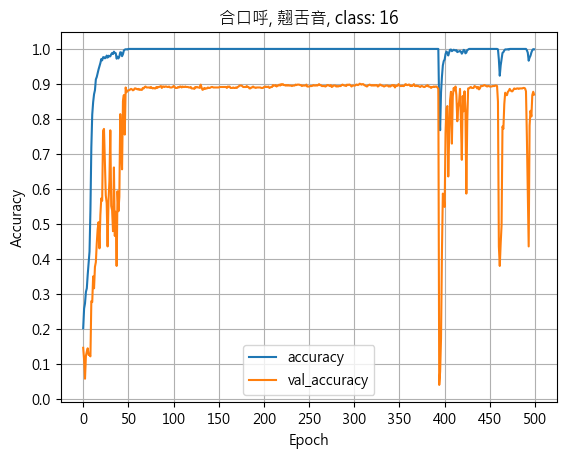

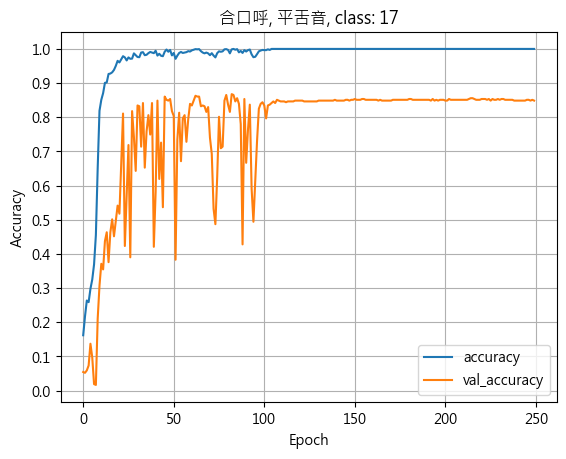

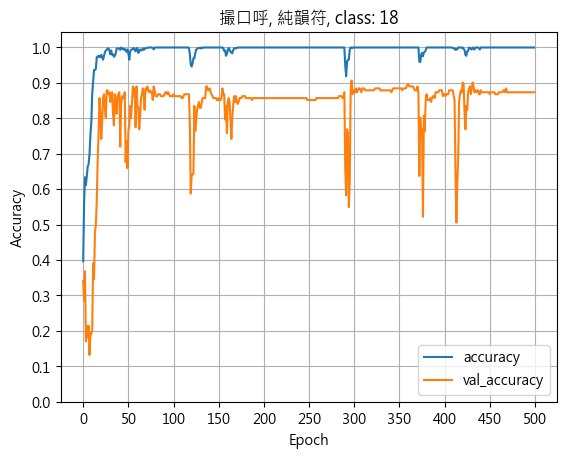

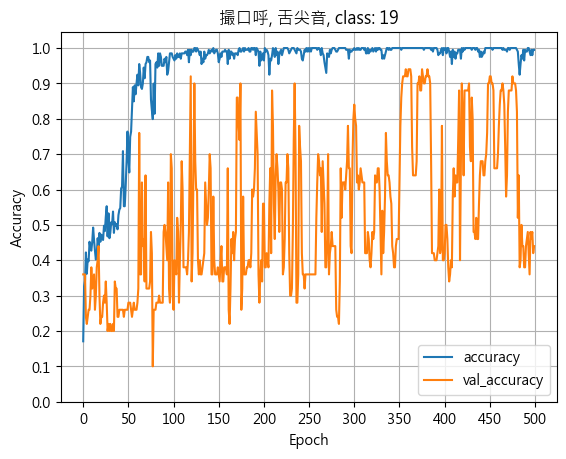

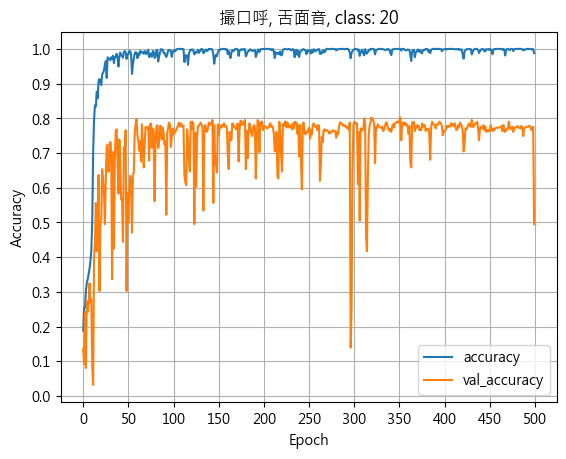

In [45]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False

for class_label, model_train_info in enumerate(model_train_info_list):
    accuracies = model_train_info.history['accuracy']
    val_accuracies = model_train_info.history['val_accuracy']
    
    best_params = json.load(
        open(
            file=f"..\\..\\grid_search\\method2_with_fake_data\\layer2\\best_parameters_record\\best_parameters_class{class_label}.json",
            mode="r"
        )
    )
    
    epochs = best_params["epochs"]
    
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    plt.title(f"{hu_yin}, {she2_yin}, class: {class_label}")
    
    plt.plot(list(range(epochs)), accuracies, label="accuracy")
    plt.plot(list(range(epochs)), val_accuracies, label="val_accuracy")
    plt.legend()
    plt.grid()
    plt.xticks(ticks = list(range(1, epochs + 1))) 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=list(range(0, epochs + 1, 50)))
    plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
    plt.show()

In [46]:
best_accuracy_list = list()

for class_label, model_train_info in enumerate(model_train_info_list):
    val_accuracies = model_train_info.history['val_accuracy']
    best_accuracy = max(val_accuracies)
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    print(f"class: {class_label}, {hu_yin}, {she2_yin}, 最高準確率: {best_accuracy}")
    best_accuracy_list.append(best_accuracy)

class: 0, 純聲符, 翹舌音, 最高準確率: 0.89952152967453
class: 1, 純聲符, 平舌音, 最高準確率: 0.8047337532043457
class: 2, 開口呼, 純韻符, 最高準確率: 0.9584905505180359
class: 3, 開口呼, 口唇音, 最高準確率: 0.8875351548194885
class: 4, 開口呼, 舌尖音, 最高準確率: 0.8738800883293152
class: 5, 開口呼, 舌根音, 最高準確率: 0.8677777647972107
class: 6, 開口呼, 翹舌音, 最高準確率: 0.8844884634017944
class: 7, 開口呼, 平舌音, 最高準確率: 0.8950819969177246
class: 8, 齊齒呼, 純韻符, 最高準確率: 0.9022082090377808
class: 9, 齊齒呼, 口唇音, 最高準確率: 0.8687499761581421
class: 10, 齊齒呼, 舌尖音, 最高準確率: 0.8685782551765442
class: 11, 齊齒呼, 舌面音, 最高準確率: 0.8249837160110474
class: 12, 合口呼, 純韻符, 最高準確率: 0.8840970396995544
class: 13, 合口呼, 口唇音, 最高準確率: 0.9532163739204407
class: 14, 合口呼, 舌尖音, 最高準確率: 0.8983050584793091
class: 15, 合口呼, 舌根音, 最高準確率: 0.8298465609550476
class: 16, 合口呼, 翹舌音, 最高準確率: 0.9006802439689636
class: 17, 合口呼, 平舌音, 最高準確率: 0.8676123023033142
class: 18, 撮口呼, 純韻符, 最高準確率: 0.906593382358551
class: 19, 撮口呼, 舌尖音, 最高準確率: 0.9399999976158142
class: 20, 撮口呼, 舌面音, 最高準確率: 0.8024390339851379


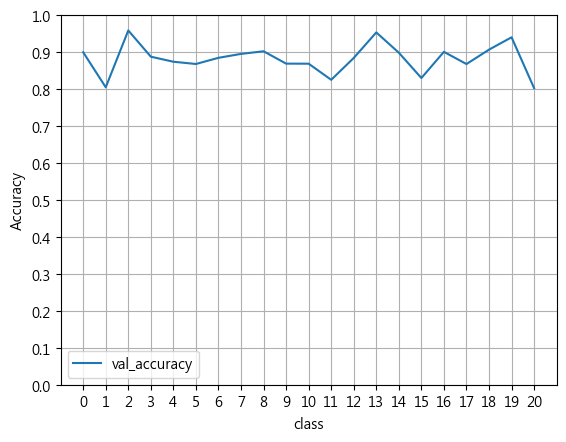

In [47]:
plt.plot(range(len(best_accuracy_list)), best_accuracy_list, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks=list(range(1, len(best_accuracy_list) + 1))) 
plt.xlabel("class")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(len(best_accuracy_list)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [48]:
model_dir_path = ".\\method2_layer2_models"
if not os.path.exists(model_dir_path):
    os.mkdir(model_dir_path)
    
for i, model in enumerate(model_list):
    model.save(filepath=f"{model_dir_path}\\class_{i}_model.h5")